# 1. Set-up
- Import libraries
- Set directories
- A function to retrieve the data about 1 star

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as f
from os import listdir

In [2]:
#path to data
path = 'data'

In [3]:
#list of star names
all_stars = np.array(sorted(listdir(path)))

In [4]:
def star_data(idx, star_names):
    ''' Returns the flux data of the star at the corresponding data at index idx as a 2d numpy array. '''
    name, date = star_info(idx, star_names)
    with f.open(f'{path}/{name}/{date}/B_H/calibration/flux/{name}_{date}_cube_flux_processed_right.fits') as hdul:
        data = hdul[0].data
    return data[0]

In [5]:
def star_info(idx, star_names):
    ''' Returns the name of the star and the date of the observation at index idx as a tuple. '''
    return star_names[idx], listdir(f'{path}/{star_names[idx]}')[0]

In [6]:
#Show which stars have more than 1 file
mask_dates = np.array([len(listdir(f'data/{all_stars[i]}'))!= 1 for i in range(len(all_stars))])
more_dates = all_stars[mask_dates]
#print(more_dates)

# 1.5 Make weird, binary and single star array

In [7]:
weird_stars = np.array(['2MASSJ11320835-5803199', '2MASSJ12041439-6418516', '2MASSJ12123577-5520273', 
             '2MASSJ12192161-6454101', '2MASSJ12205449-6457242', '2MASSJ12472196-6808397',
             '2MASSJ12582559-7028490', '2MASSJ13032904-4723160'])

In [17]:
binary_stars_og = np.array(['2MASSJ11555771-5254008', '2MASSJ12560830-6926539', '2MASSJ13015435-4249422',
          '2MASSJ13130714-4537438', 'CD-43_3604', 'CVSO_751', 'Gaia_EDR3_3008386787098934144',
          'HD_283629', 'HD_284266', 'HD_286179', 'UCAC4_454-011718', 'UCAC4_475-014428', 'UCAC4_495-030196', 
          'UCAC4_501-011878'])
binary_stars_close = np.array(['2MASSJ10065573-6352086','2MASSJ11272881-3952572','2MASSJ11445217-6438548',
                                        '2MASSJ11452016-5749094','2MASSJ12163007-6711477','2MASSJ12185802-5737191',
                                        '2MASSJ12210808-5212226','2MASSJ12234012-5616325','2MASSJ13055087-5304181',
                                        '2MASSJ13103245-4817036','2MASSJ13174687-4456534','2MASSJ13335481-6536414',
                                        'CoRoT_102718810','Gaia_EDR3_3014970387847972096','IRAS_08131-4432',
                                        'RX_J2302.6+0034','UCAC4_127-038351','UCAC4_134-015937','UCAC4_406-011818',
                                        'UCAC4_461-018326','UCAC4_482-118442','UCAC4_496-013657','UCAC4_519-042115',
                                        'V1319_TAU'])
binary_stars = np.append(binary_stars_og,binary_stars_close)

In [9]:
def mask_arr(arr, star_names):
    mask = np.ones_like(star_names, dtype = bool)
    for i in arr:
        idx = np.where(star_names == i)
        mask[idx] = False
    return mask

In [10]:
#Make array of single stars
mask = mask_arr(binary_stars, all_stars)*mask_arr(weird_stars, all_stars)
single_stars = all_stars[mask]

In [11]:
print('Single stars:', len(single_stars))
print('Binary stars:', len(binary_stars))
print('Weird stars:', len(weird_stars))

Single stars: 64
Binary stars: 38
Weird stars: 8


# 2. Cutting out central pixels
- Circle of radius 100 pixels around center
- 200 x 200 pixelsaround center

In [12]:
def mask_but_center(arr, r):
    ''' Masks everything but the area with radius r in a circle around the center. '''
    x = y = np.linspace(-(len(arr))/2, (len(arr))/2, len(arr))
    x_grid, y_grid = np.meshgrid(x, y)
    r_grid = np.sqrt(x_grid**2 + y_grid**2)
    arr[r_grid > r] = None 
    return arr

def normalize(arr):
    ''' Normalizes the array '''
    arr = np.array(arr,dtype=np.float64)
    return arr/np.nanmax(arr)

def calibration(arr, r):
    ''' Masks and then normalizes the array. '''
    mask_arr = mask_but_center(arr, r)
    norm_arr = normalize(mask_arr)
    return norm_arr

In [13]:
def print_stars(idx, star_names):
    ''' Print the masked and normalised flux image of the star at index idx. '''
    name, date = star_info(idx, star_names)
    star = calibration(star_data(idx, star_names), 100)
    
    plt.subplot(1, 2, 1)
    plt.imshow(star)
    plt.gca().invert_yaxis()
    plt.xlim(400, 624)
    plt.ylim(400, 624)

    plt.subplot(1, 2, 2)
    plt.imshow(star)
    plt.gca().invert_yaxis()
    plt.xlim(500, 524)
    plt.ylim(500, 524)

    plt.suptitle(f'{name}, {date}', y = 0.8)
    plt.show()

In [15]:
#for i in range(len(single_stars)):
#        print_stars(i, single_stars)

In [16]:
#for i in range(len(binary_stars)):
#    print_stars(i, binary_stars)

# 3. Picking the best images for our median

In [76]:
def mask_little_patch(arr, x, y, dx, dy):
    return arr[x:x+dx, y:y+dy]

def rms(arr):
    return np.std(arr)

In [96]:
stack_arr = np.zeros(len(single_stars))
for i in range(len(single_stars)):
    stack_arr[i] = rms(mask_little_patch(star_data(i, single_stars), 200, 800, 20, 20))

In [97]:
arg = np.argsort(stack_arr)
stack_arr[arg]

array([1.94074178, 2.15979862, 2.19794154, 2.22807121, 2.27714467,
       2.28335309, 2.36841941, 2.40895748, 2.41843462, 2.42854428,
       2.43019915, 2.44061089, 2.55707169, 2.64131379, 2.66210651,
       2.6657033 , 2.6992507 , 2.75776219, 2.77496576, 2.77757072,
       2.78406596, 2.78635693, 2.81717563, 2.86586356, 2.86967778,
       2.88657808, 2.91125512, 2.92489672, 2.92506742, 2.94029474,
       2.94479871, 2.96145082, 2.97980881, 3.00038338, 3.00404453,
       3.00880384, 3.04795671, 3.07090235, 3.11434698, 3.13429809,
       3.1467104 , 3.15889335, 3.20876288, 3.21813059, 3.23637486,
       3.24521708, 3.25352311, 3.35315371, 3.37601233, 3.42878866,
       3.53812742, 3.69262528, 3.77263832, 3.86449671, 3.88747907,
       4.04178333, 4.05125093, 4.05518723, 4.2151103 , 4.22925711,
       4.26156902, 4.27329731, 4.39960003, 4.48718452])

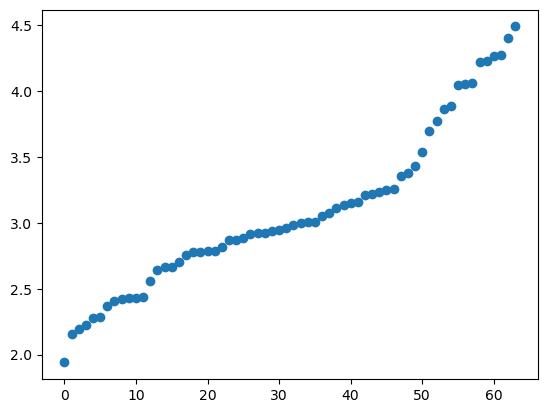

In [98]:
d = np.arange(0, 64)
plt.scatter(d, stack_arr[arg])

Make plot with rms of patch in the sky of median image vs N images used. 

# 4. Add up all arrays and take the median
- Maak array met sterren erin en de waardes die daarbij horen

In [74]:
#Only run once, it is very slow
single_stars_arr = np.array([calibration(star_data(0, single_stars), 100)])
for i in range(1, len(single_stars)):
    single_stars_arr = np.append(single_stars_arr, np.array([calibration(star_data(i, single_stars), 100)]), axis = 0) 

In [47]:
med_arr = np.median(single_stars_arr, axis = 0) #gives median of the array

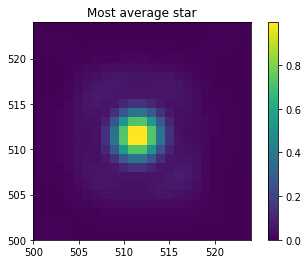

In [48]:
plt.imshow(med_arr)
plt.title('Most average star')
plt.gca().invert_yaxis()
plt.xlim(500, 524)
plt.ylim(500, 524)
plt.colorbar()
plt.show()

# 5. Subtract median star from test stars

In [49]:
def subtract_star(im, med_st):
    ''' Subtract the median star from the image and images the results'''
    im = calibration(im, 100)
    dx = im - med_st
    return dx

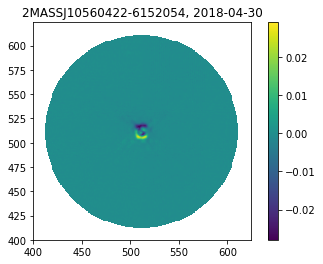

In [50]:
rest = subtract_star(star_data(0, single_stars), med_arr)
name, date = star_info(0, single_stars)
plt.title(f'{name}, {date}')
plt.imshow(rest)
plt.colorbar()
plt.xlim(400, 624)
plt.ylim(400, 624)
plt.show()

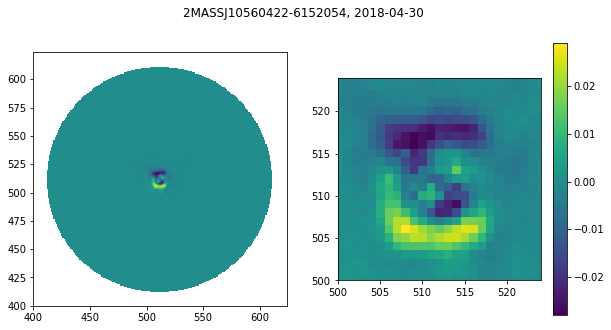

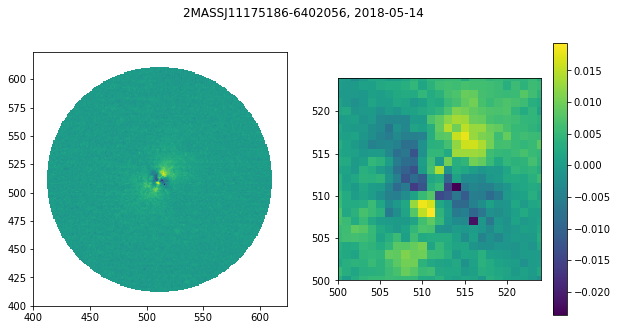

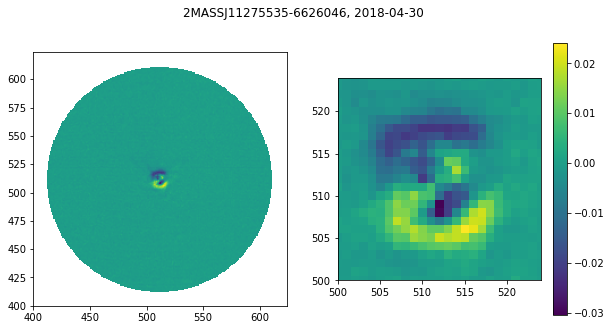

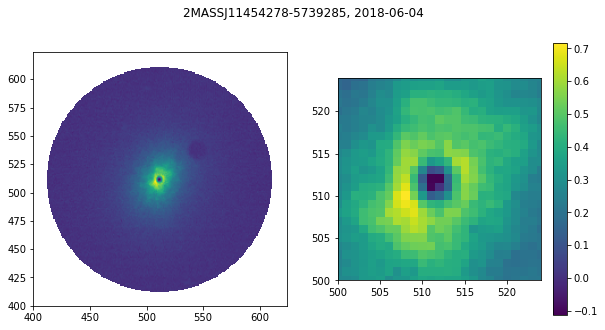

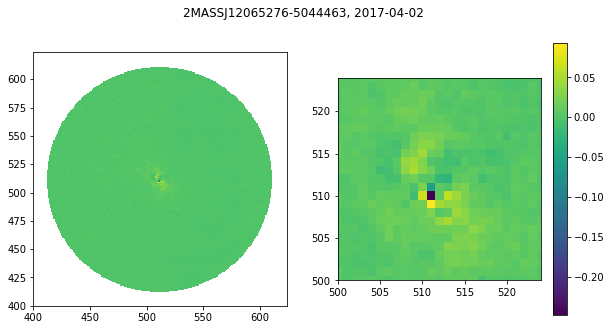

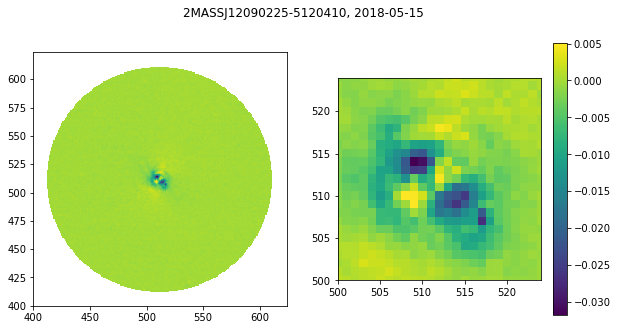

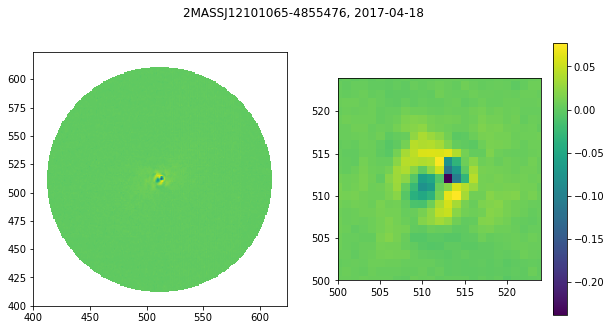

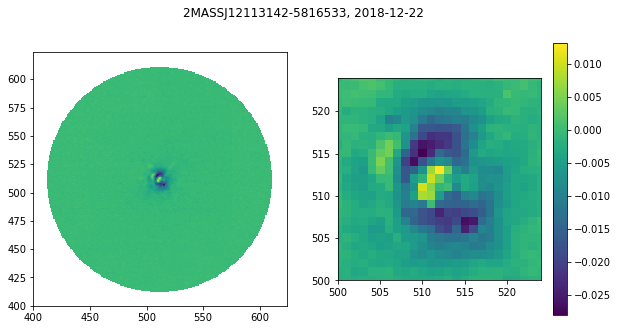

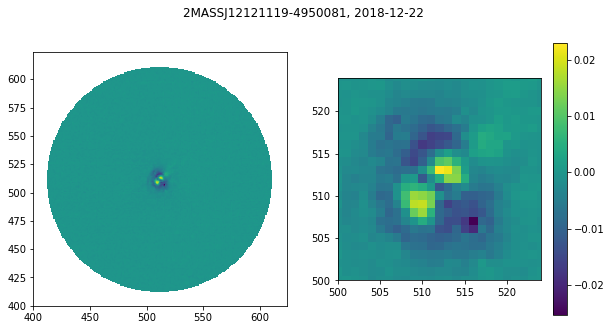

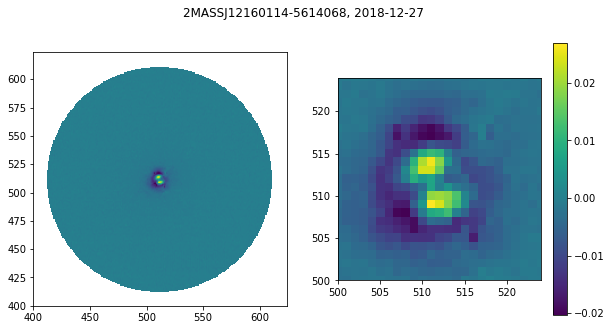

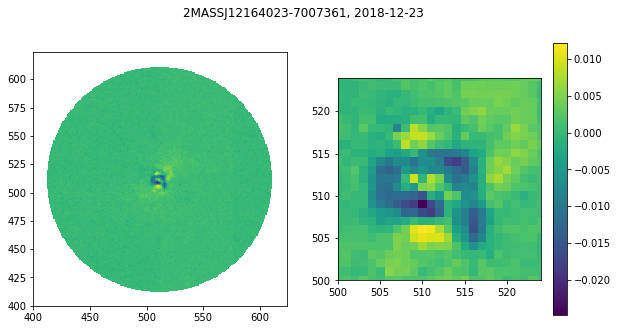

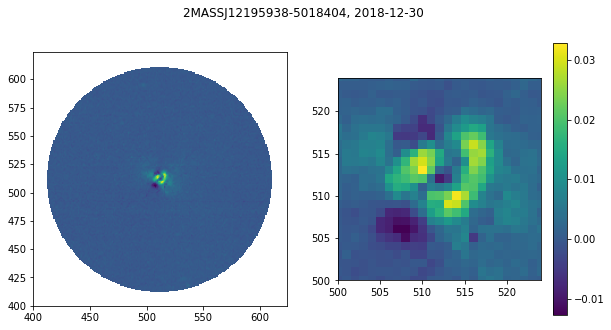

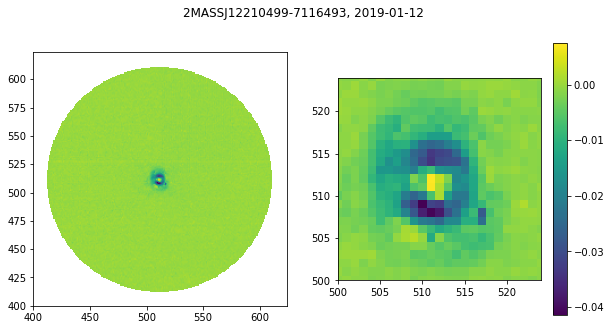

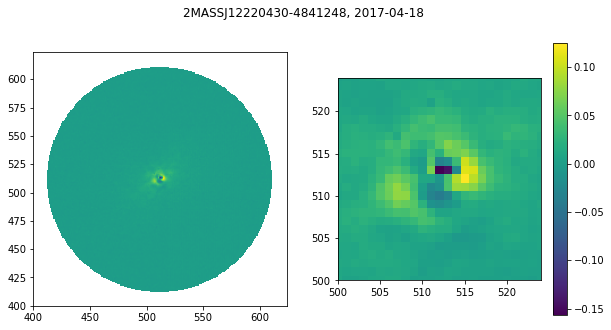

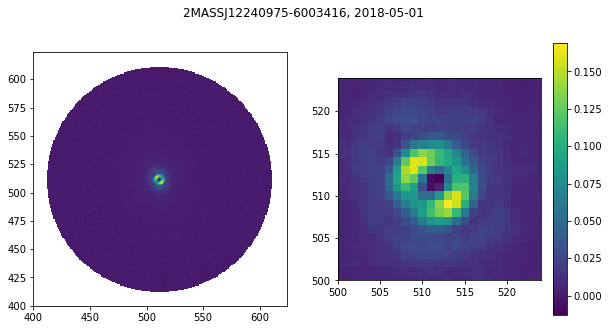

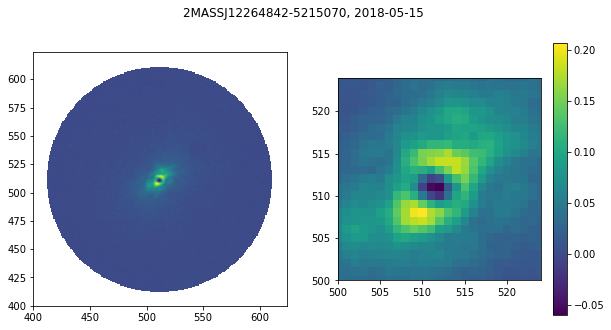

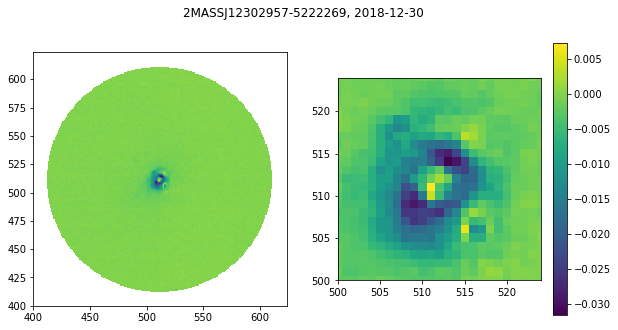

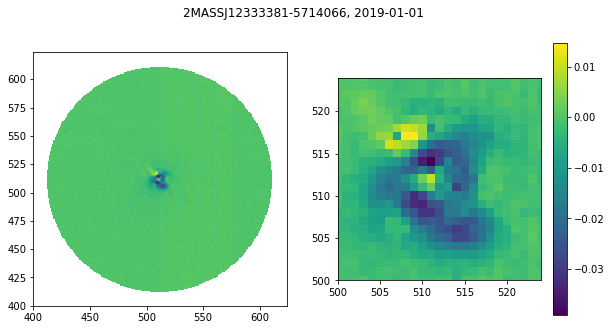

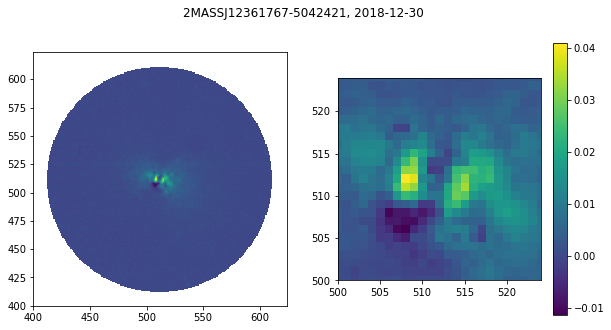

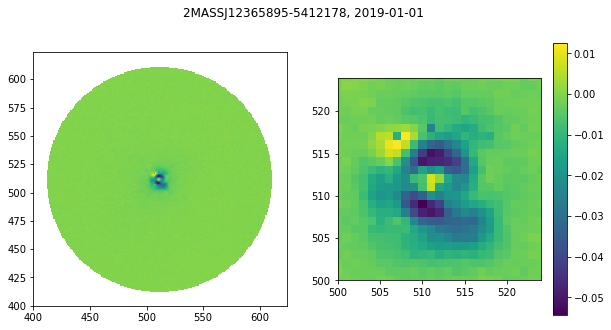

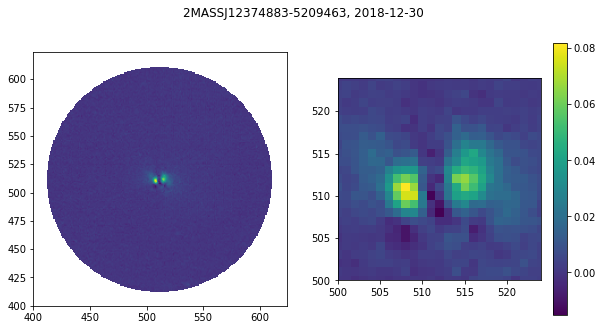

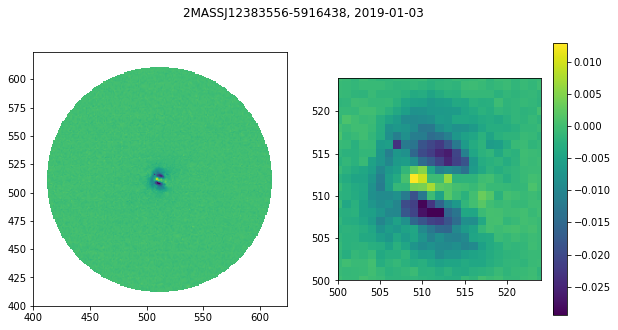

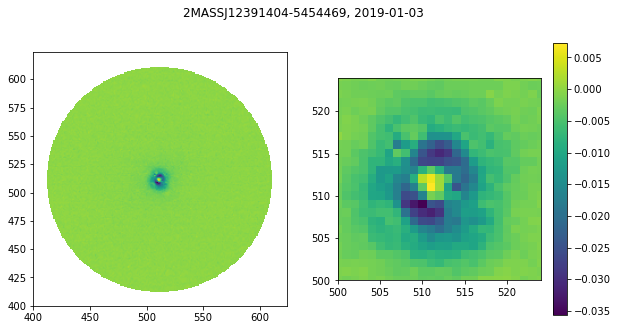

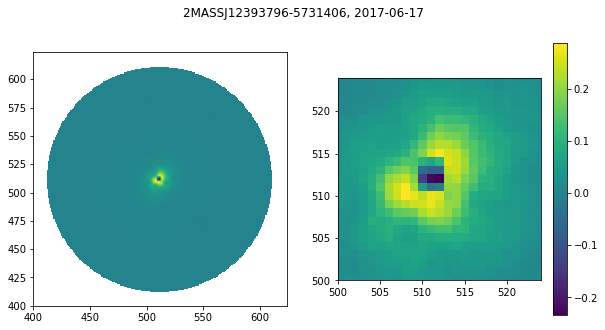

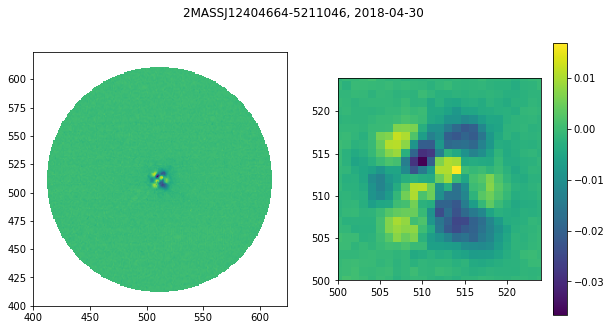

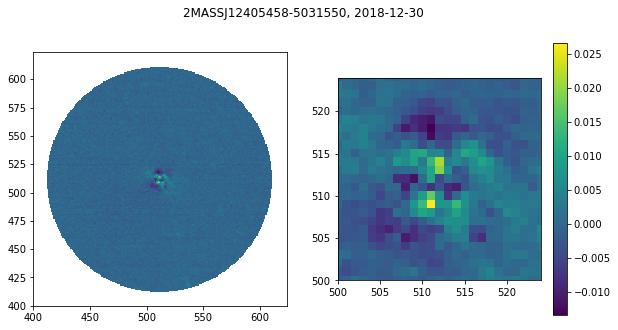

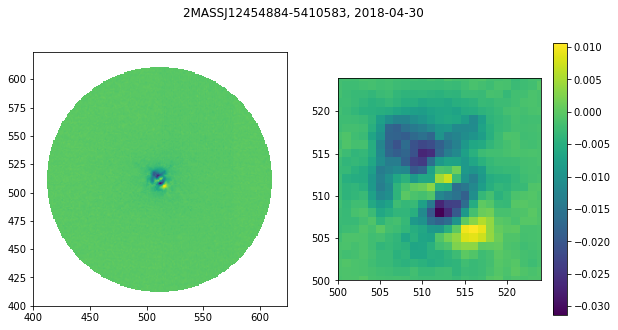

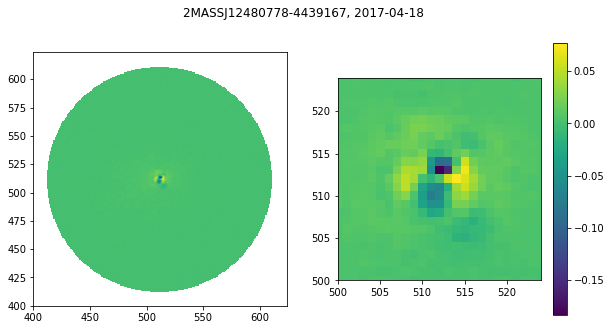

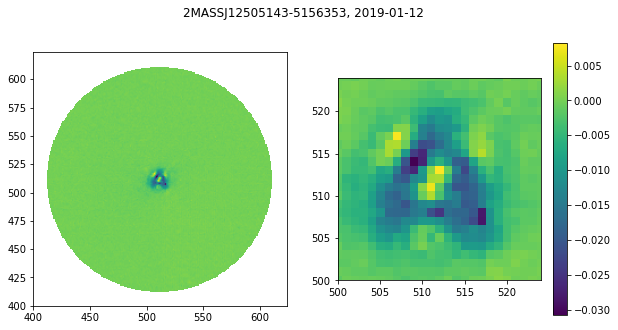

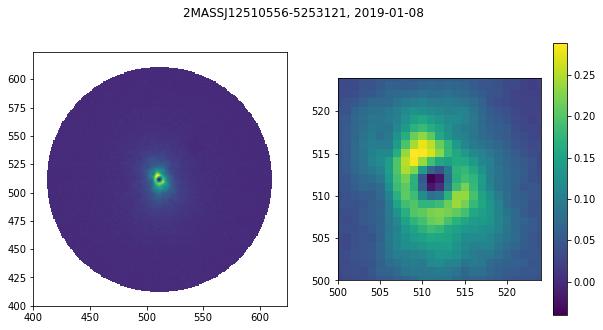

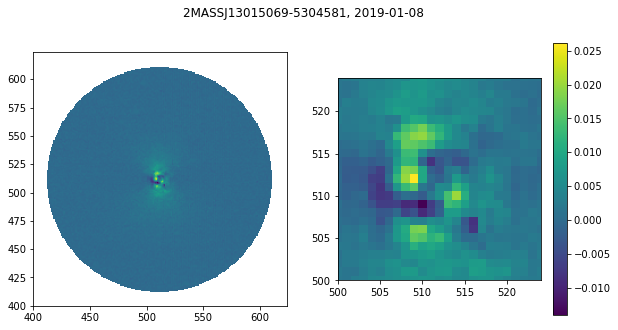

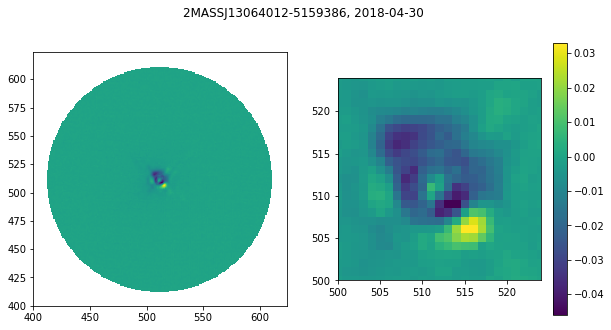

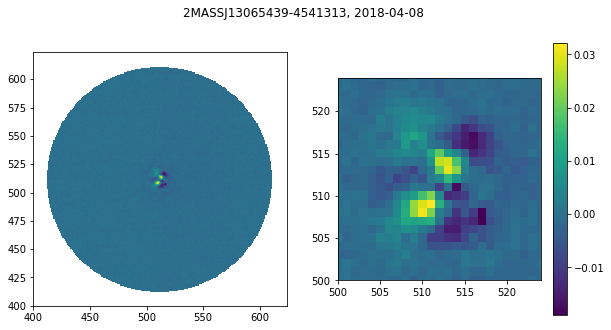

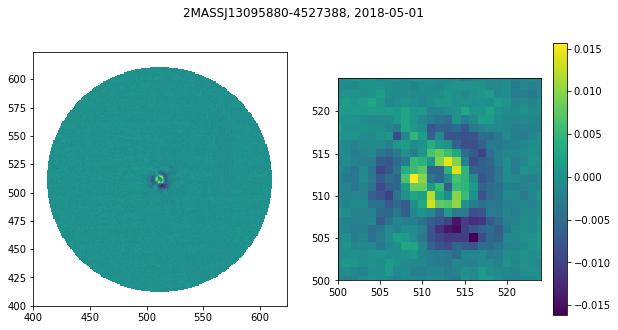

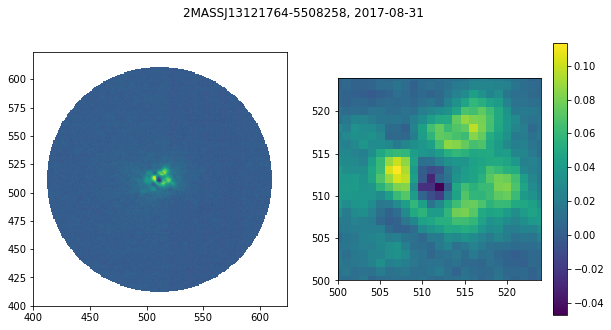

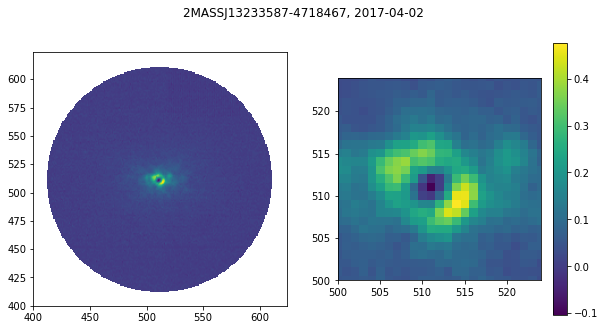

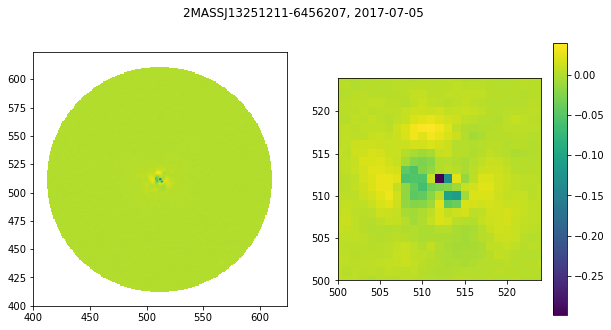

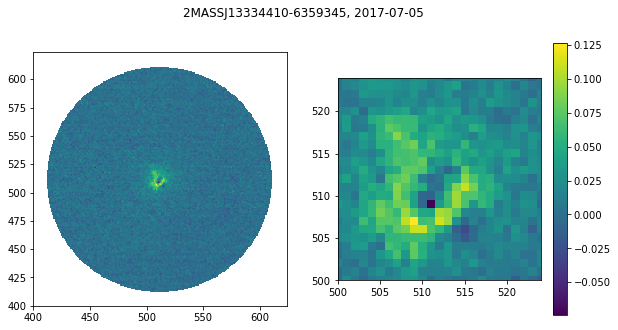

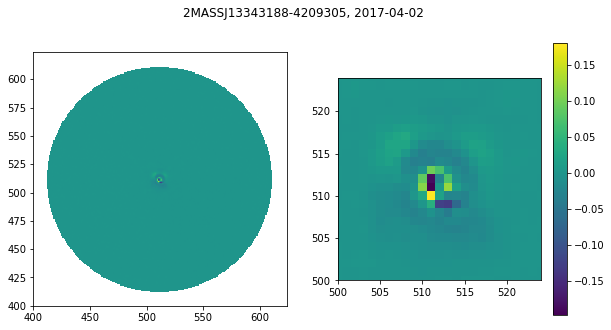

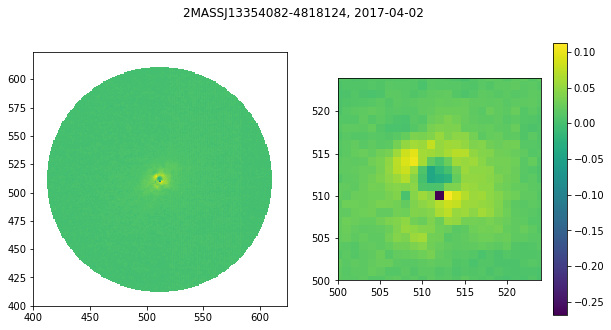

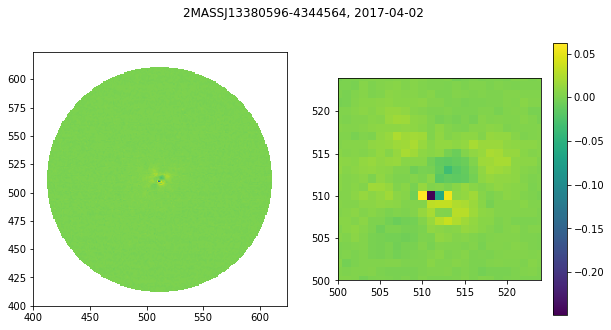

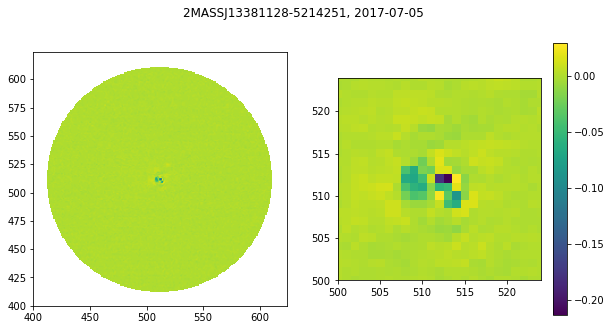

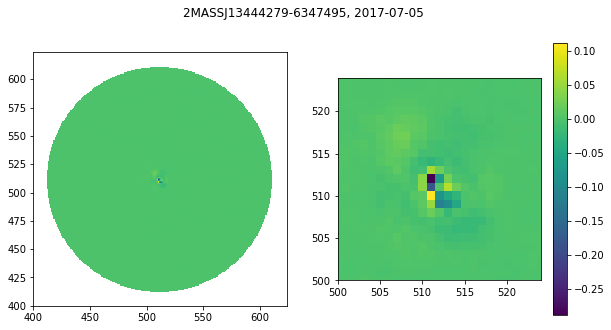

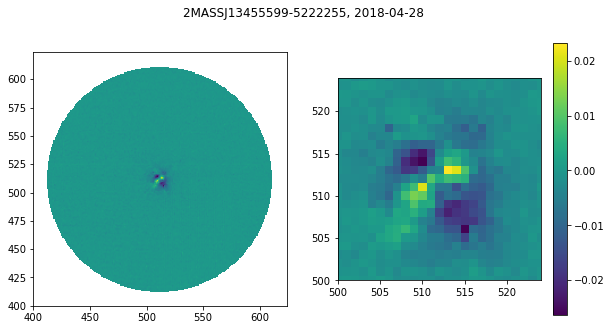

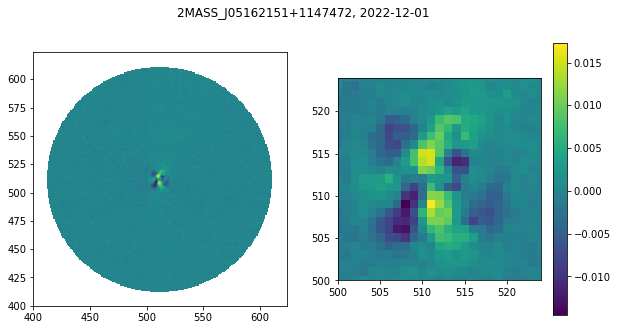

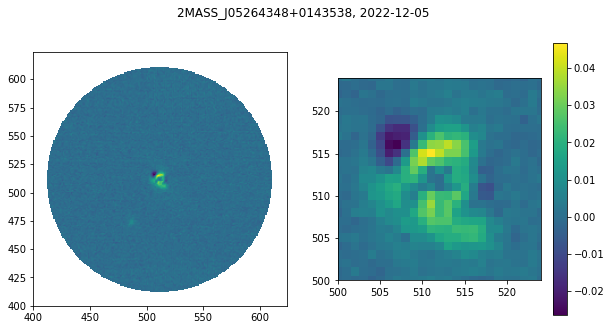

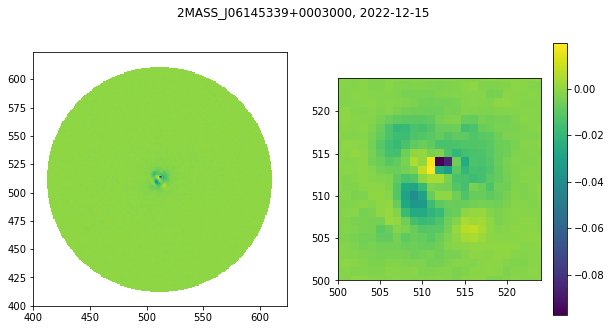

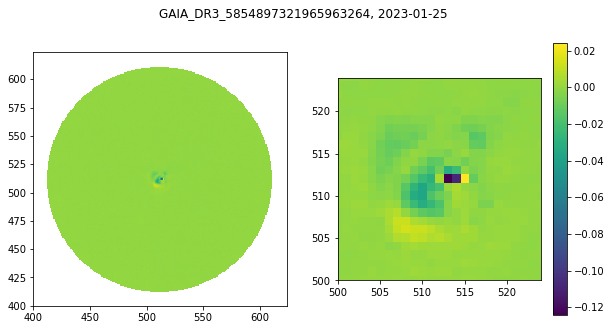

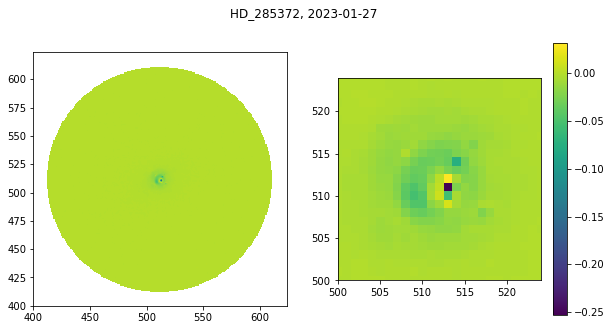

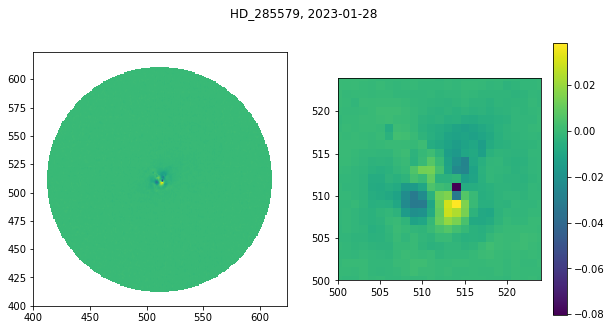

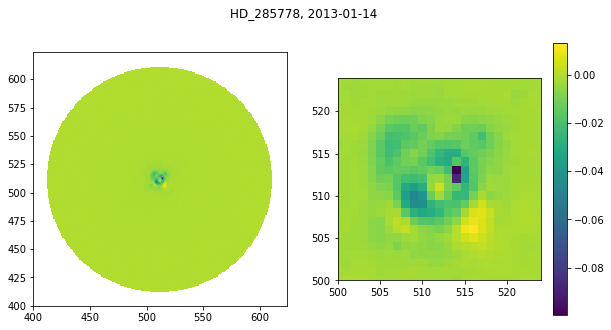

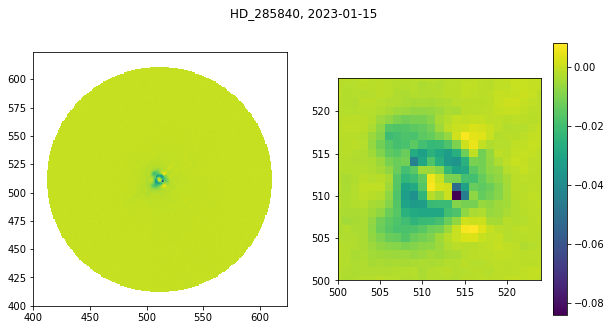

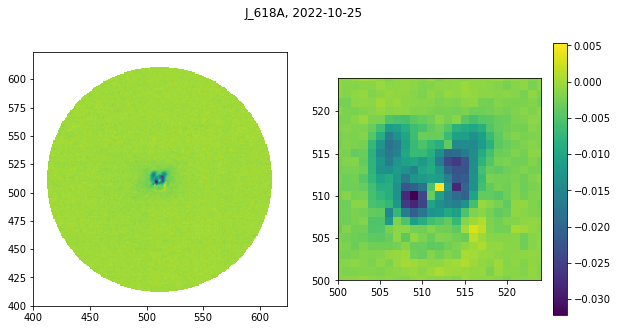

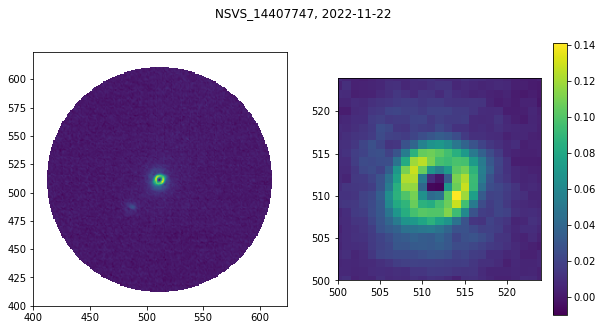

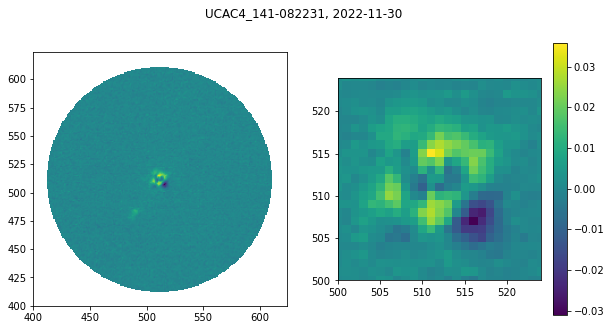

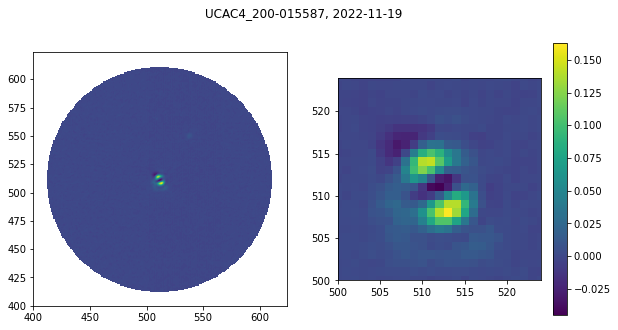

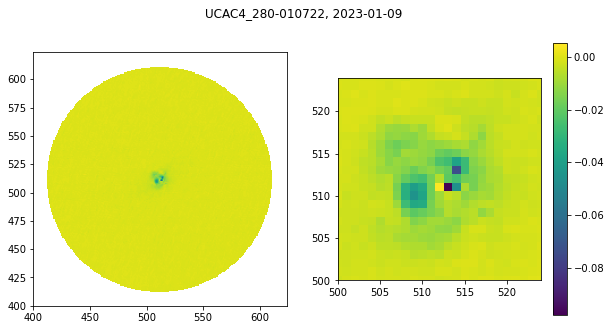

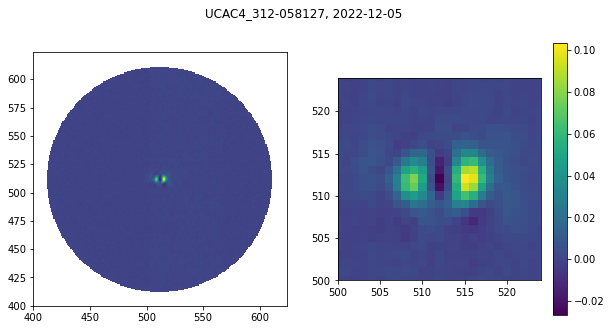

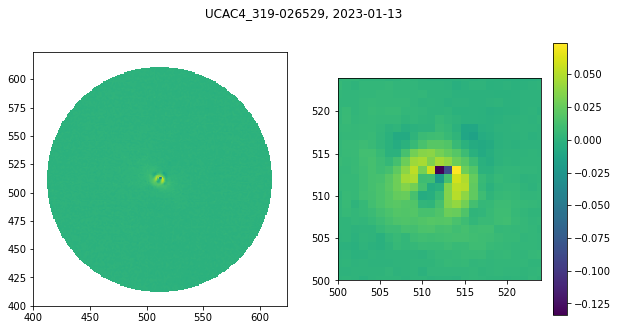

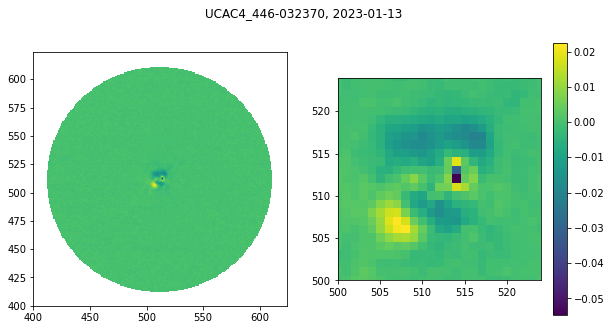

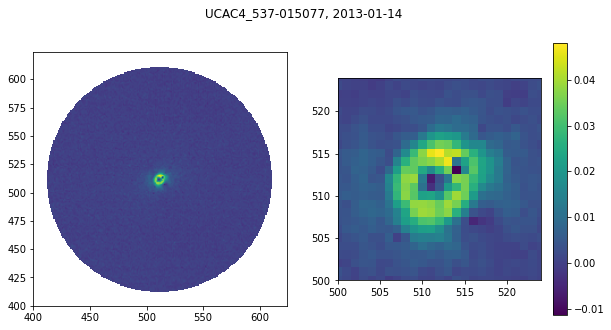

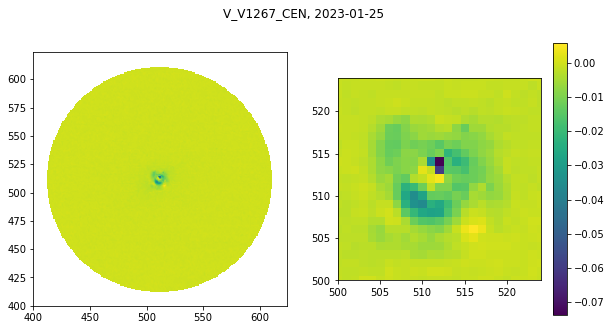

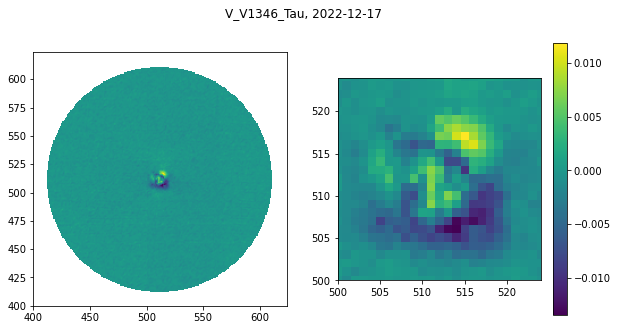

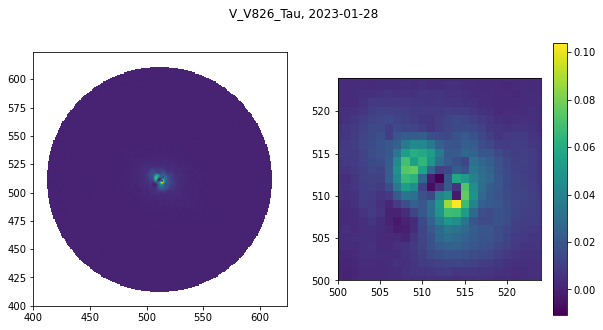

In [51]:
for i in range(len(single_stars)):
    rest = subtract_star(star_data(i, single_stars), med_arr)
    name, date = star_info(i, single_stars)
#     plt.title(f'{name}, {date}')
#     plt.imshow(rest)
#     plt.colorbar()
#     plt.xlim(500, 524)
#     plt.ylim(500, 524)
#     plt.show()
    
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(rest)
    plt.xlim(400, 624)
    plt.ylim(400, 624)

    plt.subplot(1,2,2)
    plt.imshow(rest)
    plt.colorbar()
    plt.xlim(500, 524)
    plt.ylim(500, 524)

    plt.suptitle(f'{name}, {date}')
    plt.show()

In [21]:
subtract_star(star_data(path_sin, 1), med_arr)
name, date = star_info(path_sin, 1)
plt.title(f'{name}, {date}')
plt.imshow(rest)
plt.colorbar()
plt.xlim(500, 524)
plt.ylim(500, 524)
plt.show()

NameError: name 'path_sin' is not defined

# .reg files
1. Want to open them
2. Want to be able to read them
3. Search for key word circle
4. Save x and y coordinate
    - Are all coordinates equally long? --> if not begin next at ,
    - Do not save radius too

In [ ]:
def find_x_y_reg(file, loc_circle, sep):
    ''' Opens the .reg file and returns the x and y coordinate in the file. loc_circle is the number of the line
    where the information on the circle is stored and sep is the thing used for seperating the x and y coord. '''
    with open(file, 'rt') as reg:
        data_reg = reg.readlines()
        data_reg = data_reg[loc_circle]
    
    first, second = data_reg.find(sep), data_reg.rfind(sep)
    return float(data_reg[7:first]), float(data_reg[(first+1):second])

In [ ]:
x, y = find_x_y_reg(f'data/{star}/{date}/{star}_{date}.reg', 3, ',')

In [ ]:
x